In [ ]:
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score



In [19]:
# set random seed
SEED = 12
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():	
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 12


In [20]:
device = torch.device('cuda')

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.columns)



Index(['Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close',
       'Change', 'Transaction', 'rate', 'Movement', 'MA5', 'MA10',
       'MA5_Capacity', 'BR5', 'BR10', 'High-Low', 'Open-Close', 'EMA5',
       'EMA10', 'STD20', 'RSI14', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'BB_position', 'ATR', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_hist',
       'ADX', 'DJI', 'NASDAQ', 'SOX', 'SPX', 'ADR', 'tw', 'TWD'],
      dtype='object')


In [21]:
# List of feature columns used for model training
features = ['Movement','BR5','Open-Close','BB_position','RSI14','BR10','TWD','ADX','ADR']
# Target variable to be predicted
target_feature = 'Movement'

# Split the training dataset into training and validation sets
train_data, val_data = train_test_split(df_train, test_size=0.1, shuffle=False)
 
# Extract feature columns for training and validation inputs
scaled_train_X = train_data[features]
scaled_val_X = val_data[features]

# Extract target values for training and validation outputs
train_y = train_data[target_feature].values
val_y = val_data[target_feature].values

In [22]:
# Print the class distribution of the target variable
print("Train Data Distribution:")
print(train_data['Movement'].value_counts(normalize=True))

print("\nValidation Data Distribution:")
print(val_data['Movement'].value_counts(normalize=True))

print("\Test Data Distribution:")
print(df_test['Movement'].value_counts(normalize=True))

Train Data Distribution:
Movement
0    0.519626
1    0.480374
Name: proportion, dtype: float64

Validation Data Distribution:
Movement
1    0.514905
0    0.485095
Name: proportion, dtype: float64
\Test Data Distribution:
Movement
0    0.525424
1    0.474576
Name: proportion, dtype: float64


In [23]:
#hyper parameter
sequence_length = 32
batch_size = 128
epochs = 50
lr = 0.001

In [40]:
#split data

# Define how many steps ahead to forecast (To predict stock price movement n days from now)
forecast_horizon = 1

# convert time series data into input-output sequences
# x_data: feature data
# y_data: target data
# sequence_length: number of past time steps used as input
# forecast_horizon: how far in the future to predict
def create_sequences(x_data, y_data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(x_data) - sequence_length - (forecast_horizon - 1)):
        
        # Window of past observations as input
        X.append(x_data[i:(i + sequence_length)])
        
		# Ttarget value at the forecast horizon as label
        y.append(y_data[i + sequence_length + forecast_horizon - 1])
        
    return np.array(X), np.array(y)

# Create sequences for training and validation datasets
X_train, y_train = create_sequences(scaled_train_X, train_y, sequence_length, forecast_horizon)
X_val, y_val = create_sequences(scaled_val_X, val_y, sequence_length, forecast_horizon)

# Convert numpy array to pytorch tensors for model training
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

X_train: torch.Size([3280, 32, 9])
y_train: torch.Size([3280])
X_val: torch.Size([337, 32, 9])
y_val: torch.Size([337])


In [25]:
# pytorch dataset 

class StockDataset(Dataset):
    def __init__(self, X, y):
        # Store input sequences and  labels
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Retrieve one sample by index
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
# shuffle=False to preserve the order for evaluation, avoid data leakage
# drop_last=True to ensure all batches have the same size

train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) 

val_dataset = StockDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Design the LSTM model
 
class StockLSTM(nn.Module):
	# Initialize the model architecture
	def __init__(self, input_size, hidden_dim, num_layers, output_size):
		super(StockLSTM, self).__init__()
		self.hidden_dim = hidden_dim
		self.num_layers = num_layers

		# LSTM layer to extract time series features from input sequences
		self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True, dropout = 0.2,bidirectional=False) 
		
		# Batch normalization
		self.norm = nn.BatchNorm1d(hidden_dim)
		
		# dropout
		self.dropout = nn.Dropout(0)

		# linear layer to map hidden state to output
		self.fc1 = nn.Linear(hidden_dim, 1)
		
	def forward(self, x):
		# LSTM layer
		out, _ = self.lstm(x)

		# Take the output from the last time step
		out = out[:, -1, :]

		# Apply batch normalization and dropout
		out = self.norm(out)
		out = self.dropout(out)
		
		# Final linear layer for prediction
		out = self.fc1(out)
		return out

#parameter
input_size = len(features)
hidden_dim = 128
num_layers = 1
output_size = 1

model = StockLSTM(input_size, hidden_dim, num_layers, output_size).to(device)
print(model)

StockLSTM(
  (lstm): LSTM(9, 128, batch_first=True, dropout=0.2)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


c:\Users\cengy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [27]:
# Handle class imbalance for binary classification

# Count the number of samples in positive class (movement = 1)
counts = train_data['Movement'].value_counts()

# Compute the weight for the positive class (class 1)
pos_weight_value = counts[0] / counts[1]
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)
print(f"Calculated pos_weight (for class 1): {pos_weight_value:.4f}")

# loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# variable to track the best model
best_val_f1 = 0.0 
best_val_acc = 0.0
best_epoch = 0

# list to record the history value (used for plot)
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
train_f1_history = []
val_f1_history = []

Calculated pos_weight (for class 1): 1.0817


In [ ]:
# function for train one epoch
def train(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    Args:
        model: PyTorch model
        dataloader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: torch.device

    Returns:
        avg_loss: Average loss over the epoch
        avg_acc: Average accuracy over the epoch
        epoch_f1: F1-score for the epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        
        # BCE loss requires float labels with shape (batch_size,1)
        y_batch = y_batch.to(device).float().unsqueeze(1) 
        
        # Forward pass
        outputs = model(X_batch) 
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Multiply batch loss by batch size to get total loss for the batch
        running_loss += loss.item() * X_batch.size(0)
        
		# Convert logits to probabilities and then to binary predictions
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float() 
        
		# Update accuracy
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        
        # Store predictions and true labels for F1-score calculation
        all_preds.extend(preds.detach().cpu().numpy().flatten())
        all_targets.extend(y_batch.detach().cpu().numpy().flatten())

    # Compute average loss, accuracy, and F1-score
    avg_loss = running_loss / total
    avg_acc = correct / total
    epoch_f1 = f1_score(all_targets, all_preds, average='binary')
    
    return avg_loss, avg_acc, epoch_f1

In [ ]:
# function for validation one epoch
def valid(model, dataloader, criterion, device):
    """
    Evaluate the model on validation data (no gradient computation).

    Args:
        model: PyTorch model
        dataloader: DataLoader for validation data
        criterion: Loss function
        device: torch.device (CPU or GPU)

    Returns:
        avg_loss: Average loss over the validation set
        avg_acc: Average accuracy
        epoch_f1: F1-score for validation
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    if len(dataloader) == 0:
        return 0.0, 0.0, 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float().unsqueeze(1)
            
			# Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Multiply batch loss by batch size to get total loss
            running_loss += loss.item() * X_batch.size(0)
            
			# Convert logits to probabilities and then to binary predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
			# Update accuracy
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

			# Store predictions and true labels for F1-score calculation
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(y_batch.cpu().numpy().flatten())
    
    # Compute average loss, accuracy, and F1-score
    avg_loss = running_loss / total
    avg_acc = correct / total
    epoch_f1 = f1_score(all_targets, all_preds, average='binary')
    
    return avg_loss, avg_acc, epoch_f1

In [ ]:
# train and validation

for epoch in range(epochs):
    
    # Training phase
    train_loss, train_acc, train_f1 = train(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validation phase
    val_loss, val_acc, val_f1 = valid(
        model, val_loader, criterion, device
    )
    
    # 4. Record training and validation history
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_f1_history.append(train_f1)
    val_f1_history.append(val_f1)
     
    # Display metrics for the current epoch
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # 6. Save the best model
    # Save model weights if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_epoch = epoch + 1
        print(f"  (New best ACC found: {best_val_acc:.4f}) -> Saving model...")
        torch.save(model.state_dict(), "best_model.pth")

print(f"\nBest epoch found at: {best_epoch} (Val F1: {best_val_f1:.4f}, Val Acc: {best_val_acc:.4f})")

Epoch 1/50 | Train Loss: 0.7206 | Val Acc: 0.5608 | Val F1: 0.5488
  (New best ACC found: 0.5608) -> Saving model...
Epoch 2/50 | Train Loss: 0.7200 | Val Acc: 0.5430 | Val F1: 0.5650
Epoch 3/50 | Train Loss: 0.7082 | Val Acc: 0.5846 | Val F1: 0.6000
  (New best ACC found: 0.5846) -> Saving model...
Epoch 4/50 | Train Loss: 0.6994 | Val Acc: 0.5668 | Val F1: 0.5437
Epoch 5/50 | Train Loss: 0.6934 | Val Acc: 0.5579 | Val F1: 0.5240
Epoch 6/50 | Train Loss: 0.6890 | Val Acc: 0.5490 | Val F1: 0.5065
Epoch 7/50 | Train Loss: 0.6858 | Val Acc: 0.5460 | Val F1: 0.5049
Epoch 8/50 | Train Loss: 0.6828 | Val Acc: 0.5282 | Val F1: 0.4821
Epoch 9/50 | Train Loss: 0.6798 | Val Acc: 0.5312 | Val F1: 0.4803
Epoch 10/50 | Train Loss: 0.6767 | Val Acc: 0.5371 | Val F1: 0.4834
Epoch 11/50 | Train Loss: 0.6735 | Val Acc: 0.5312 | Val F1: 0.4626
Epoch 12/50 | Train Loss: 0.6702 | Val Acc: 0.5312 | Val F1: 0.4626
Epoch 13/50 | Train Loss: 0.6671 | Val Acc: 0.5312 | Val F1: 0.4662
Epoch 14/50 | Train Loss:

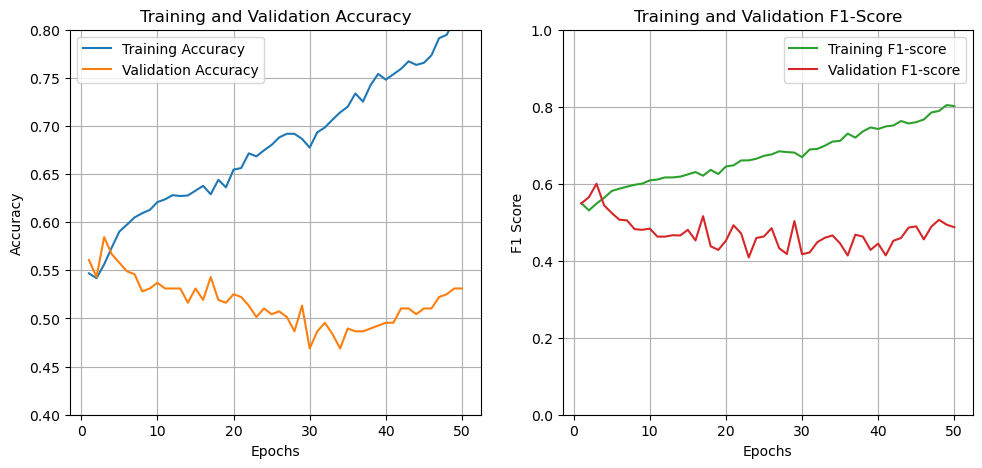

In [ ]:
# visualize the performance on train and valid step

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(18, 5)) 

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy', color='tab:blue')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy', color='tab:orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim(0.4, 0.8) # Limit y-axis for better visualization
plt.legend()
plt.grid(True)

# plot F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_history, label='Training F1-score', color='tab:green')
plt.plot(epochs_range, val_f1_history, label='Validation F1-score', color='tab:red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1-Score')
plt.ylim(0.0, 1.0) 
plt.legend()
plt.grid(True)


In [ ]:
# Use the complete df_train dataset to retrain the model for the best number of epochs

full_X = df_train[features]
full_y = df_train[target_feature].values 

# Create sequences for LSTM input
X_full_train, y_full_train = create_sequences(
    full_X, 
    full_y.reshape(-1, 1), 
    sequence_length, 
    forecast_horizon
)

# Convert to PyTorch tensors

# Features must be float
X_full_train = torch.tensor(X_full_train, dtype=torch.float32)

# Labels must be float and shaped (N, 1) for BCEWithLogitsLoss
y_full_train = torch.tensor(y_full_train, dtype=torch.float32).view(-1, 1)

# Create dataset and dataLoader
full_train_dataset = StockDataset(X_full_train, y_full_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize a new model
final_model = StockLSTM(input_size, hidden_dim, num_layers, output_size=1).to(device)

# Define Loss function and Optimizer
criterion = nn.BCEWithLogitsLoss()
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=1e-4)

final_model.train()

#training
for epoch in range(best_epoch):
    loop_loss = 0.0
    for X_batch, y_batch in full_train_loader:
        X_batch = X_batch.to(device)
        
        # Ensure labels are float and have shape (batch_size, 1)
        y_batch = y_batch.to(device).float()
        if y_batch.dim() == 1: 
             y_batch = y_batch.unsqueeze(1)

		# Forward pass
        outputs = final_model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        
		# Backward pass and optimization
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()
        
        loop_loss += loss.item()

    # Print epoch log every 5 epochs or last epoch
    if (epoch + 1) % 5 == 0 or (epoch + 1) == best_epoch:
        avg_loss = loop_loss / len(full_train_loader)
        print(f'Retraining Epoch [{epoch+1}/{best_epoch}], Avg Loss: {avg_loss:.6f}')

Retraining final model for 3 epochs...


c:\Users\cengy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Retraining Epoch [3/3], Avg Loss: 0.685302


In [ ]:
# test the model

# Ensure model is on device
final_model.to(device)
final_model.eval() 

# Prepare input data for testing
# Concatenate last 'sequence_length' days from training set with test set
# That is, to predict 2025-01-01, we need the last `sequence_length` days from 2024

last_sequence_train = df_train[features].tail(sequence_length) 
df_test['Date'] = pd.to_datetime(df_test['Date'])
test_features = df_test[features]

input_data = pd.concat([last_sequence_train, test_features], axis=0)
input_data_scaled = input_data[features].values

# Create sequences
X_test, _ = create_sequences(input_data_scaled, input_data_scaled, sequence_length, forecast_horizon) 
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Align actual test labels
y_test_actual = df_test[target_feature].iloc[forecast_horizon - 1:].values.astype(int)

# Ensure length consistency
min_len = min(len(y_test_actual), len(X_test))
X_test = X_test[:min_len]
y_test_actual = y_test_actual[:min_len]

# 3. Make predictions with confidence scores
results_list = []
confidence_threshold = 0.3  # Threshold for high-confidence predictions

print(f"Starting prediction on {len(X_test)} test samples...")

with torch.no_grad():
    for i in range(len(X_test)): 
        question = X_test[i].unsqueeze(0) 
        
        # Get model output (Logits)
		# Since we used BCEWithLogitsLoss during training, the model's final layer does not apply Sigmoid,
		# so the output values range from -infinite to +infinite 
        prediction_logit = final_model(question) 
        
		# convert logits to probability
		# During training, BCEWithLogitsLoss automatically applies this step;
		# but in testing, we need to manually apply Sigmoid to map the scores into (0,1).
        prob = torch.sigmoid(prediction_logit).item()
        
        # Determine predicted class (0 = down, 1 = up)
        pred_class = 1 if prob > 0.5 else 0
        
        # Compute confidence score: 
		# (distance from 0.5) * 2
        confidence = abs(prob - 0.5) * 2 
        
		# Filter predictions by confidence threshold
        if confidence > confidence_threshold:
            filtered_pred = pred_class
        else:
            filtered_pred = -1 
        
		# Store results
        result_row = {
            'Date': df_test['Date'].iloc[i + forecast_horizon - 1], 
            'Actual_Movement': y_test_actual[i],
            'Predicted_Class': pred_class, 
            # Raw probability of rise      
            'Prob_Rise': prob,             
            # Confidence score: if model has confidence in prediction, store prediction (0 or 1), otherwise store -1       
            'Confidence': confidence,            
            'Filtered_Prediction': filtered_pred 
        }
        results_list.append(result_row)

results = pd.DataFrame(results_list)

Starting prediction on 236 test samples...


Performance:
Overall Accuracy: 55.93% (All samples)
Classification Report (Overall):
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       124
           1       0.53      0.62      0.57       112

    accuracy                           0.56       236
   macro avg       0.56      0.56      0.56       236
weighted avg       0.56      0.56      0.56       236

High Confidence Metric (Threshold > 0.3)
High confidence: 50/236 samples (21.19%)
Filtered Accuracy: 60.00%

Plot saved to 'prediction_analysis_summary.png'
Results saved to stock_predictions_with_confidence.csv


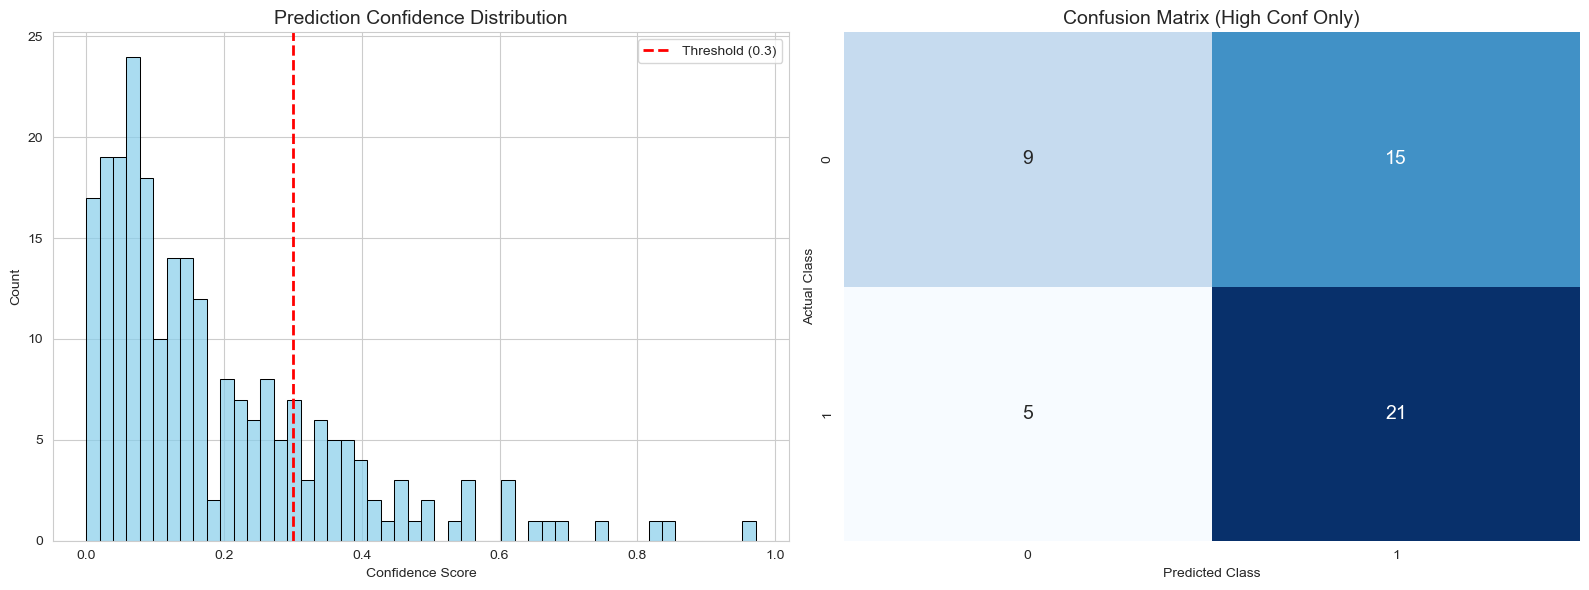

In [ ]:
# Visualize the performance

# Set Seaborn style for plots
sns.set_style("whitegrid")

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# plot prediction confidence distribution
sns.histplot(results['Confidence'], bins=50, kde=False, color='skyblue', edgecolor='k', alpha=0.7, ax=axes[0])
axes[0].axvline(confidence_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({confidence_threshold})')
axes[0].set_title('Prediction Confidence Distribution', fontsize=14)
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Count')
axes[0].legend()

# Compute and print performance metrics 
print("Performance:")

# Standard Accuracy using all predictions
acc_overall = (results['Predicted_Class'] == results['Actual_Movement']).mean()
print(f"Overall Accuracy: {acc_overall:.2%} (All samples)")
print("Classification Report (Overall):")
print(classification_report(results['Actual_Movement'], results['Predicted_Class'], zero_division=0))

# High Confidence Accuracy (predictions with confidence > threshold)
valid_preds = results[results['Filtered_Prediction'] != -1]
coverage = len(valid_preds) / len(results) if len(results) > 0 else 0

print(f"High Confidence Metric (Threshold > {confidence_threshold})")
print(f"High confidence: {len(valid_preds)}/{len(results)} samples ({coverage:.2%})")

if not valid_preds.empty:
    acc_filtered = (valid_preds['Filtered_Prediction'] == valid_preds['Actual_Movement']).mean()
    print(f"Filtered Accuracy: {acc_filtered:.2%}")
    
    # plot confusioin matrix
    cm = confusion_matrix(valid_preds['Actual_Movement'], valid_preds['Filtered_Prediction'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=[0, 1], yticklabels=[0, 1], ax=axes[1], annot_kws={"size": 14})
    axes[1].set_title(f'Confusion Matrix (High Conf Only)', fontsize=14)
    axes[1].set_xlabel('Predicted Class')
    axes[1].set_ylabel('Actual Class')
else:
    print("No predictions met the confidence threshold.")
    axes[1].text(0.5, 0.5, 'No High Confidence Samples', ha='center', va='center', fontsize=14)

# save the plot and result
plt.tight_layout()
plt.savefig('prediction_analysis_summary.png')
print(f"\nPlot saved to 'prediction_analysis_summary.png'")

output_path = "stock_predictions_with_confidence.csv"
results.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"Results saved to {output_path}")